

# Plotting Fronts

This uses MetPy to decode text surface analysis bulletins from the Weather Prediction Center.
The features in this bulletin are then plotted on a map, making use of MetPy's various
path effects for matplotlib than can be used to represent a line as a traditional front.


In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.colors as mcolors

import timezonefinder    as tzf
import pytz              as pytz
import urllib    as urllib
import shutil
import metpy as metpy
import cartopy.crs       as ccrs
import cartopy.feature   as cfeature

import os                as     os
import pygrib            as pygrib

from statsmodels.distributions.empirical_distribution import ECDF


from metpy.cbook import get_test_data
from metpy.io import parse_wpc_surface_bulletin
from metpy.plots import (add_metpy_logo, ColdFront, OccludedFront, StationaryFront,
                         StationPlot, WarmFront)

working_dir = "./temp_sfc_analysis/"

os.system("rm -frv "+working_dir+"/*")

tz='America/Denver'



####################################################
####################################################
####################################################
#
# Mines Colors and Fonts
#

Mines_Blue = "#002554"


plt.rcParams.update({'text.color'      : Mines_Blue,
                     'axes.labelcolor' : Mines_Blue,
					 'axes.edgecolor'  : Mines_Blue,
					 'xtick.color'     : Mines_Blue,
					 'ytick.color'     : Mines_Blue})


#
####################################################
####################################################
####################################################



Get Wweather LUT



In [2]:

#display(time_frame)
print(pd.Timestamp.now().to_pydatetime())
print(pd.Timestamp.now().to_pydatetime()  )
print(pd.Timestamp.now().round('3h').to_pydatetime())

2024-02-20 08:28:55.201962
2024-02-20 08:28:55.202191
2024-02-20 09:00:00


lag_hours = 1
lag_minutes = 60


time_data = np.arange('2024-01-26T03', '2024-01-26T15',15, dtype='datetime64[m]')

time_data_3 = pd.to_datetime(  time_data - np.timedelta64(90,'m') - np.timedelta64(lag_minutes,'m' ) ).round('3h')

time_frame = pd.DataFrame(data={"Now":time_data})
time_frame["Past_Nearest_3"] = time_data_3 
time_frame["time_diff"]      = time_frame["Now"] - time_frame["Past_Nearest_3"]

time_frame

---

### Timings for each run

The Realtime WRF is generated every 6 hr at best.  The model takes 3 hr to 

| Model Product Time (UTC) | Wallclock Start Time (UTC) |
|:------------------------:|:--------------------------:|
|        00 UTC            |        03 UTC              |
|        06 UTC            |        09 UTC              |
|        12 UTC            |        15 UTC              |
|        18 UTC            |        21 UTC              |

In [3]:
####################################################
####################################################
####################################################
#
# Identify Specific Run by Wall Clock Window
#

beta_on   = 0
lag_hours = 1
lag_minutes = 90

current_datetime = dt.datetime.utcnow()



map_datetime  =  pd.to_datetime( (current_datetime - dt.timedelta(minutes=90)) - dt.timedelta(minutes=lag_minutes)  ).round('3h')
ndfd_datetime =  map_datetime - dt.timedelta(hours=1)
    


#
# Burn Current Time to File in WRF Root Directory
#


product_string_YYYY_MM_DD_HH00UTC =  map_datetime.strftime("%Y-%m-%d %H00 UTC")
fronts_date_YYYYMMDD_HH00         =  map_datetime.strftime("%Y%m%d_%H00")
ndfd_date_YYYYMMDD_HH00           = ndfd_datetime.strftime("%Y%m%d_%H00")

print("Current Time ", current_datetime)
print("Product Time ", map_datetime)
print("  Label Time ", product_string_YYYY_MM_DD_HH00UTC)
print(" Fronts Time ", fronts_date_YYYYMMDD_HH00)
print("   NDFD Time ", ndfd_date_YYYYMMDD_HH00)


#
####################################################
####################################################
####################################################

Current Time  2024-02-20 15:28:55.207385
Product Time  2024-02-20 12:00:00
  Label Time  2024-02-20 1200 UTC
 Fronts Time  20240220_1200
   NDFD Time  20240220_1100


In [4]:
fronts_date_YYYYMMDD_HH00

'20240220_1200'

Pull Fronts

https://thredds.ucar.edu/thredds/catalog/noaaport/text/fronts/catalog.html

In [5]:
fronts_url = "https://thredds.ucar.edu/thredds/fileServer/" +  \
             "noaaport/text/fronts/Fronts_highres_KWBC_"    +  \
             fronts_date_YYYYMMDD_HH00 + ".txt"

temp_front_file = "./temp_sfc_analysis/fronts.txt"


print("downloading "+ fronts_url)
print("         to "+ temp_front_file)


urllib.request.urlretrieve(fronts_url, temp_front_file)

df = parse_wpc_surface_bulletin(temp_front_file)



downloading https://thredds.ucar.edu/thredds/fileServer/noaaport/text/fronts/Fronts_highres_KWBC_20240220_1200.txt
         to ./temp_sfc_analysis/fronts.txt


Gridded Analyses

https://thredds.ucar.edu/thredds/catalog/grib/NCEP/NDFD/NWS/CONUS/CONDUIT/catalog.html

```
374:267673420:vt=2024013021:surface:70 hour fcst:WX Weather information [WxInfo]:
    ndata=2953665:undef=1479384:mean=1.29788:min=0:max=40
    grid_template=30:winds(N/S):
	Lambert Conformal: (2145 x 1377) input WE|EW:SN output WE:SN res 0
	Lat1 20.191999 Lon1 238.445999 LoV 265.000000
	LatD 25.000000 Latin1 25.000000 Latin2 25.000000
	LatSP -90.000000 LonSP 0.000000
	North Pole (2145 x 1377) Dx 2539.703000 m Dy 2539.703000 m 
```

ndfd_url  = "https://thredds.ucar.edu/thredds/dodsC/" +  \
            "grib/NCEP/NDFD/NWS/CONUS/CONDUIT/"       +  \
            "NDFD_NWS_CONUS_conduit_2p5km_"           + \
            ndfd_date_YYYYMMDD_HH00 + ".grib2"

ndfd_http = "https://thredds.ucar.edu/thredds/fileServer/" + \
            "grib/NCEP/NDFD/NWS/CONUS/CONDUIT/"       +  \
            "NDFD_NWS_CONUS_conduit_2p5km_"           + \
            ndfd_date_YYYYMMDD_HH00 + ".grib2"

print("cracking NDFD grib file "+ndfd_url)

ds_ndfd   = xr.open_dataset(filename_or_obj=ndfd_url)

ds_ndfd   = ds_ndfd.metpy.parse_cf()
ndfd_crs  = ds_ndfd.metpy_crs.metpy.cartopy_crs

wx_code = ds_ndfd["Weather_string_surface"][0,:,:]   #.sel(time3=map_datetime)
wx_code.values[wx_code.values==0]=[np.nan]
print("Weather Time Stamp:",wx_code.coords)









fig = plt.figure(figsize=[11,8])
ax  = plt.subplot(1, 1, 1,
                  projection = ndfd_crs)
wx_code.plot(cmap = "nipy_spectral")
ax.add_feature(cfeature.STATES.with_scale('50m'),    
               linewidth = 0.25, 
               edgecolor = "grey")
plt.show()



---

Best Forecast Fields

url_ndfd = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/NDFD/NWS/CONUS/NOAAPORT/NDFD_NWS_CONUS_2p5km_20240121_0000.grib2"

ds_ndfd2   = xr.open_dataset(filename_or_obj=url_ndfd)
ds_ndfd2   = ds_ndfd2.metpy.parse_cf()

proj_ndfd = ds_ndfd2.metpy_crs.metpy.cartopy_crs


fig = plt.figure(figsize   = [11, 8], 
                 facecolor = 'white')

ax = fig.add_subplot(1, 1, 1, 
                     projection=proj_ndfd)

ds_ndfd["Categorical_Rain_surface"][2,:,:].plot.imshow(ax=ax)

ax.add_feature(cfeature.STATES.with_scale('50m'),    
               linewidth = 0.25, 
               edgecolor = "white")


plt.show()

MSLP from HRRR

https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/RAP/CONUS_40km/RR_CONUS_40km_20240126_1200.grib2

https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/RAP/CONUS_40km/RR_CONUS_40km_20240126_1200.grib2

MSLP_MAPS_System_Reduction_msl

In [81]:
min_rain =  0.005
max_rain =  1

min_snow =  0.0001
max_snow =  0.25

min_icep =  0.0001
max_icep =  0.25

min_frzr =  0.0001
max_frzr =  0.25

min_alpha = 0.25
max_alpha = 1.00

hrrr_url = "https://thredds.ucar.edu/thredds/dodsC/" +  \
           "grib/NCEP/RAP/CONUS_20km/"               +  \
           "RR_CONUS_20km_"                          + \
           fronts_date_YYYYMMDD_HH00 + ".grib2"

mslp_name = "MSLP_MAPS_System_Reduction_msl"


print("cracking HRRR grib file "+hrrr_url)

ds_hrrr       = xr.open_dataset(filename_or_obj=hrrr_url)
hrrr_time_dim = ds_hrrr[mslp_name].dims[0]


ds_hrrr   = ds_hrrr.metpy.parse_cf()
hrrr_crs  = ds_hrrr.metpy_crs.metpy.cartopy_crs

mslp        = ds_hrrr["MSLP_MAPS_System_Reduction_msl"][0,:,:]   #.sel(hrrr_time_dim=map_datetime)
mslp.values = mslp.values / 100





rain_cat       = ds_hrrr[         "Categorical_Rain_surface"][0,:,:] 
snow_cat       = ds_hrrr[         "Categorical_Snow_surface"][0,:,:] 
icep_cat       = ds_hrrr[  "Categorical_Ice_Pellets_surface"][0,:,:] 
frzr_cat       = ds_hrrr["Categorical_Freezing_Rain_surface"][0,:,:] 

rain_cat.values[rain_cat.values != 1] = np.nan
snow_cat.values[snow_cat.values != 1] = np.nan
icep_cat.values[icep_cat.values != 1] = np.nan
frzr_cat.values[frzr_cat.values != 1] = np.nan



precip_rate_acc = ds_hrrr["Precipitation_rate_surface"][0,:,:]
precip_rate_on  = ds_hrrr["Precipitation_rate_surface"][0,:,:]

precip_rate_acc.values = precip_rate_acc.values * 3600.

precip_rate_on.values[precip_rate_on.values > 0]  = 1
precip_rate_on.values[precip_rate_on.values != 1] = np.nan

prec_accum_acc = ds_hrrr[                       "Total_precipitation_surface_Mixed_intervals_Accumulation"][0,:,:]
rain_accum_acc = ds_hrrr[                       "Total_precipitation_surface_Mixed_intervals_Accumulation"][0,:,:]
snow_accum_acc = ds_hrrr["Water_equivalent_of_accumulated_snow_depth_surface_Mixed_intervals_Accumulation"][0,:,:]
frzr_accum_acc = ds_hrrr[                             "Freezing_Rain_surface_Mixed_intervals_Accumulation"][0,:,:]
icep_accum_acc = ds_hrrr[                               "Frozen_Rain_surface_Mixed_intervals_Accumulation"][0,:,:]
conv_accum_acc = ds_hrrr[                           "Convective_precipitation_surface_1_Hour_Accumulation"][0,:,:]



prec_accum_on = ds_hrrr[                       "Total_precipitation_surface_Mixed_intervals_Accumulation"][0,:,:]
rain_accum_on = ds_hrrr[                       "Total_precipitation_surface_Mixed_intervals_Accumulation"][0,:,:]
snow_accum_on = ds_hrrr["Water_equivalent_of_accumulated_snow_depth_surface_Mixed_intervals_Accumulation"][0,:,:]
frzr_accum_on = ds_hrrr[                             "Freezing_Rain_surface_Mixed_intervals_Accumulation"][0,:,:]
icep_accum_on = ds_hrrr[                               "Frozen_Rain_surface_Mixed_intervals_Accumulation"][0,:,:]
conv_accum_on = ds_hrrr[                           "Convective_precipitation_surface_1_Hour_Accumulation"][0,:,:]

conv_accum_on.values = conv_accum_on.values/prec_accum_on.values
rain_accum_on.values = rain_accum_on.values/prec_accum_on.values
snow_accum_on.values = snow_accum_on.values/prec_accum_on.values
frzr_accum_on.values = frzr_accum_on.values/prec_accum_on.values
icep_accum_on.values = icep_accum_on.values/prec_accum_on.values




rain_accum_acc.values = prec_accum_acc.values - snow_accum_acc.values - frzr_accum_acc.values - icep_accum_acc.values





prec_accum_acc.values[prec_accum_acc.values < min_snow] = np.nan 
rain_accum_acc.values[rain_accum_acc.values < min_snow] = np.nan 
snow_accum_acc.values[snow_accum_acc.values < min_snow] = np.nan 
frzr_accum_acc.values[frzr_accum_acc.values < min_snow] = np.nan 
icep_accum_acc.values[icep_accum_acc.values < min_snow] = np.nan 







rain_accum_acc.attrs["long_name"] = "Rain (Mixed_intervals Accumulation) @ Ground or water surface"



display(ds_hrrr)


display(prec_accum_on)
display(rain_accum_on)

cracking HRRR grib file https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/RAP/CONUS_20km/RR_CONUS_20km_20240220_1200.grib2


/var/folders/0c/8xbkg06s6cz0yy2505h06nlm00017d/T/ipykernel_56513/2239234135.py:76: RuntimeWarning: invalid value encountered in divide
  conv_accum_on.values = conv_accum_on.values/prec_accum_on.values
/var/folders/0c/8xbkg06s6cz0yy2505h06nlm00017d/T/ipykernel_56513/2239234135.py:77: RuntimeWarning: invalid value encountered in divide
  rain_accum_on.values = rain_accum_on.values/prec_accum_on.values
/var/folders/0c/8xbkg06s6cz0yy2505h06nlm00017d/T/ipykernel_56513/2239234135.py:78: RuntimeWarning: divide by zero encountered in divide
  snow_accum_on.values = snow_accum_on.values/prec_accum_on.values
/var/folders/0c/8xbkg06s6cz0yy2505h06nlm00017d/T/ipykernel_56513/2239234135.py:78: RuntimeWarning: invalid value encountered in divide
  snow_accum_on.values = snow_accum_on.values/prec_accum_on.values
/var/folders/0c/8xbkg06s6cz0yy2505h06nlm00017d/T/ipykernel_56513/2239234135.py:79: RuntimeWarning: divide by zero encountered in divide
  frzr_accum_on.values = frzr_accum_on.values/prec_accu

<xarray.Dataset>
Dimensions:                                                                             (
                                                                                         time: 21,
                                                                                         time_bounds_1: 2,
                                                                                         time1: 21,
                                                                                         time1_bounds_1: 2,
                                                                                         time2: 47,
                                                                                         ...
                                                                                         isobaric1: 37,
                                                                                         height_above_ground: 1,
                                                                                         height_above_ground4: 2,
                                                                                         height_above_ground1: 2,
                                                                                         depth_below_surface: 1,
                                                                                         height_above_ground2: 2)
Coordinates: (12/23)
    reftime                                                                             datetime64[ns] ...
  * time                                                                                (time) datetime64[ns] ...
  * time1                                                                               (time1) datetime64[ns] ...
  * time2                                                                               (time2) datetime64[ns] ...
  * pressure_difference_layer                                                           (pressure_difference_layer) float32 ...
  * pressure_difference_layer1                                                          (pressure_difference_layer1) float32 ...
    ...                                                                                  ...
  * isobaric1                                                                           (isobaric1) float32 ...
  * height_above_ground                                                                 (height_above_ground) float32 ...
  * height_above_ground4                                                                (height_above_ground4) float32 ...
  * height_above_ground1                                                                (height_above_ground1) float32 ...
  * depth_below_surface                                                                 (depth_below_surface) float32 ...
  * height_above_ground2                                                                (height_above_ground2) float32 ...
Dimensions without coordinates: time_bounds_1, time1_bounds_1, time2_bounds_1,
                                pressure_difference_layer_bounds_1,
                                pressure_difference_layer1_bounds_1,
                                height_above_ground_layer_bounds_1,
                                height_above_ground_layer1_bounds_1,
                                pressure_difference_layer2_bounds_1,
                                pressure_difference_layer3_bounds_1,
                                isobaric_layer_bounds_1
Data variables: (12/103)
    LambertConformal_Projection                                                         int32 ...
    time_bounds                                                                         (time, time_bounds_1) datetime64[ns] ...
    time1_bounds                                                                        (time1, time1_bounds_1) datetime64[ns] ...
    time2_bounds                                                                        (time2, time2_bounds_1) datetime64[ns] ...
    pr

<xarray.DataArray 'Total_precipitation_surface_Mixed_intervals_Accumulation' (
                                                                              y: 225,
                                                                              x: 301)>
array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.0625, 0.125 , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.0625, 0.0625, 0.    , ..., 0.75  , 0.8125, 0.875 ],
       [0.0625, 0.0625, 0.    , ..., 1.0625, 1.1875, 1.25  ],
       [0.    , 0.0625, 0.0625, ..., 1.25  , 1.3125, 1.375 ]], dtype=float32)
Coordinates:
    reftime    datetime64[ns] 2024-02-20T12:00:00
    time2      datetime64[ns] 2024-02-20T13:00:00
  * x          (x) float32 -3.332e+06 -3.312e+06 ... 2.743e+06 2.763e+06
  * y          (y) float32 -5.889e+05 -5.686e+05 ... 3.942e+06 3.962e+06
    metpy_crs  object Projection: lambert_conformal_conic
Attributes: (12/14)
    long_name:                       Total precipitation (Mixed_intervals Acc...
    units:                           kg.m-2
    abbreviation:                    APCP
    grid_mapping:                    LambertConformal_Projection
    Grib_Statistical_Interval_Type:  Accumulation
    Grib_Variable_Id:                VAR_0-1-8_L1_Imixed_S1
    ...                              ...
    Grib2_Parameter_Category:        Moisture
    Grib2_Parameter_Name:            Total precipitation
    Grib2_Level_Type:                1
    Grib2_Level_Desc:                Ground or water surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  Accumulation

<xarray.DataArray 'Total_precipitation_surface_Mixed_intervals_Accumulation' (
                                                                              y: 225,
                                                                              x: 301)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  1.,  1., ..., nan, nan, nan],
       ...,
       [ 1.,  1., nan, ...,  1.,  1.,  1.],
       [ 1.,  1., nan, ...,  1.,  1.,  1.],
       [nan,  1.,  1., ...,  1.,  1.,  1.]], dtype=float32)
Coordinates:
    reftime    datetime64[ns] 2024-02-20T12:00:00
    time2      datetime64[ns] 2024-02-20T13:00:00
  * x          (x) float32 -3.332e+06 -3.312e+06 ... 2.743e+06 2.763e+06
  * y          (y) float32 -5.889e+05 -5.686e+05 ... 3.942e+06 3.962e+06
    metpy_crs  object Projection: lambert_conformal_conic
Attributes: (12/14)
    long_name:                       Total precipitation (Mixed_intervals Acc...
    units:                           kg.m-2
    abbreviation:                    APCP
    grid_mapping:                    LambertConformal_Projection
    Grib_Statistical_Interval_Type:  Accumulation
    Grib_Variable_Id:                VAR_0-1-8_L1_Imixed_S1
    ...                              ...
    Grib2_Parameter_Category:        Moisture
    Grib2_Parameter_Name:            Total precipitation
    Grib2_Level_Type:                1
    Grib2_Level_Desc:                Ground or water surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  Accumulation

9.6
12.8


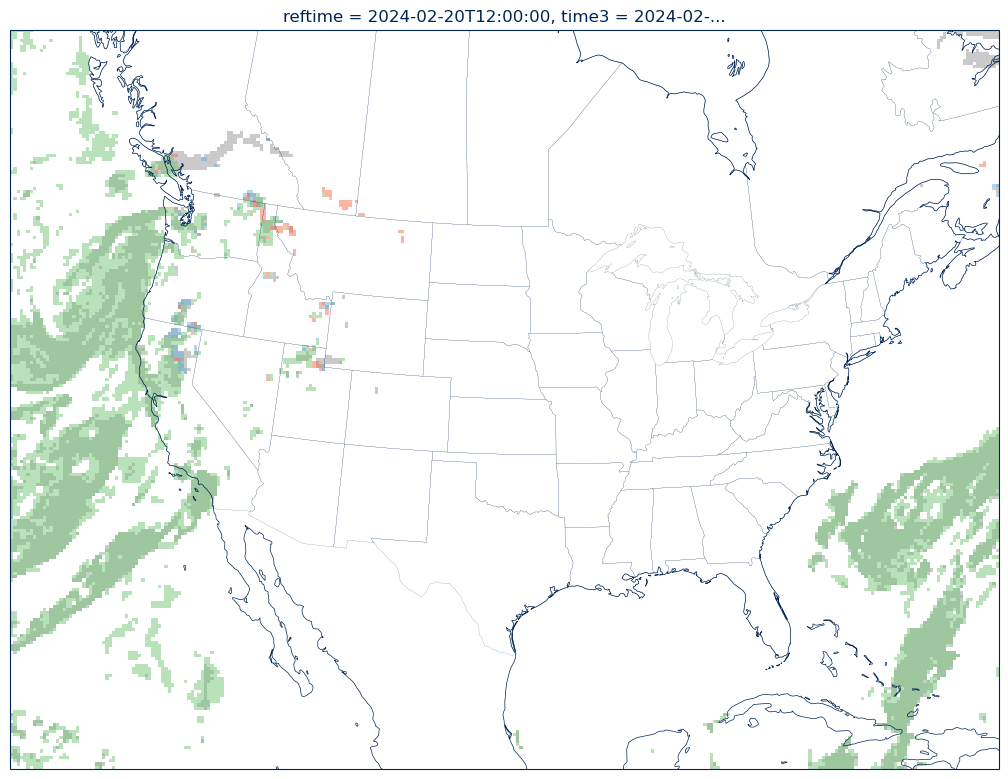

In [90]:
fig = plt.figure(figsize=[6.4*2,4.8*2])
ax  = fig.add_subplot(1, 1, 1, projection=hrrr_crs)
precip_rate_on.plot.imshow(cmap='Greys',   ax=ax, transform = hrrr_crs, add_colorbar = False, alpha=0.5)
rain_cat.plot.imshow(cmap='Greens',  ax=ax, transform = hrrr_crs, add_colorbar = False, alpha=0.5)
snow_cat.plot.imshow(cmap='Blues',   ax=ax, transform = hrrr_crs, add_colorbar = False, alpha=0.5)
icep_cat.plot.imshow(cmap='Purples', ax=ax, transform = hrrr_crs, add_colorbar = False, alpha=0.5)
frzr_cat.plot.imshow(cmap='Reds',    ax=ax, transform = hrrr_crs, add_colorbar = False, alpha=0.5)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), 
               linewidth = 0.5,
               edgecolor = Mines_Blue)
ax.add_feature(cfeature.STATES.with_scale('50m'), 
               linewidth = 0.1,
               edgecolor = Mines_Blue)

print(fig.get_figheight())
print(fig.get_figwidth())

9.6
32.0


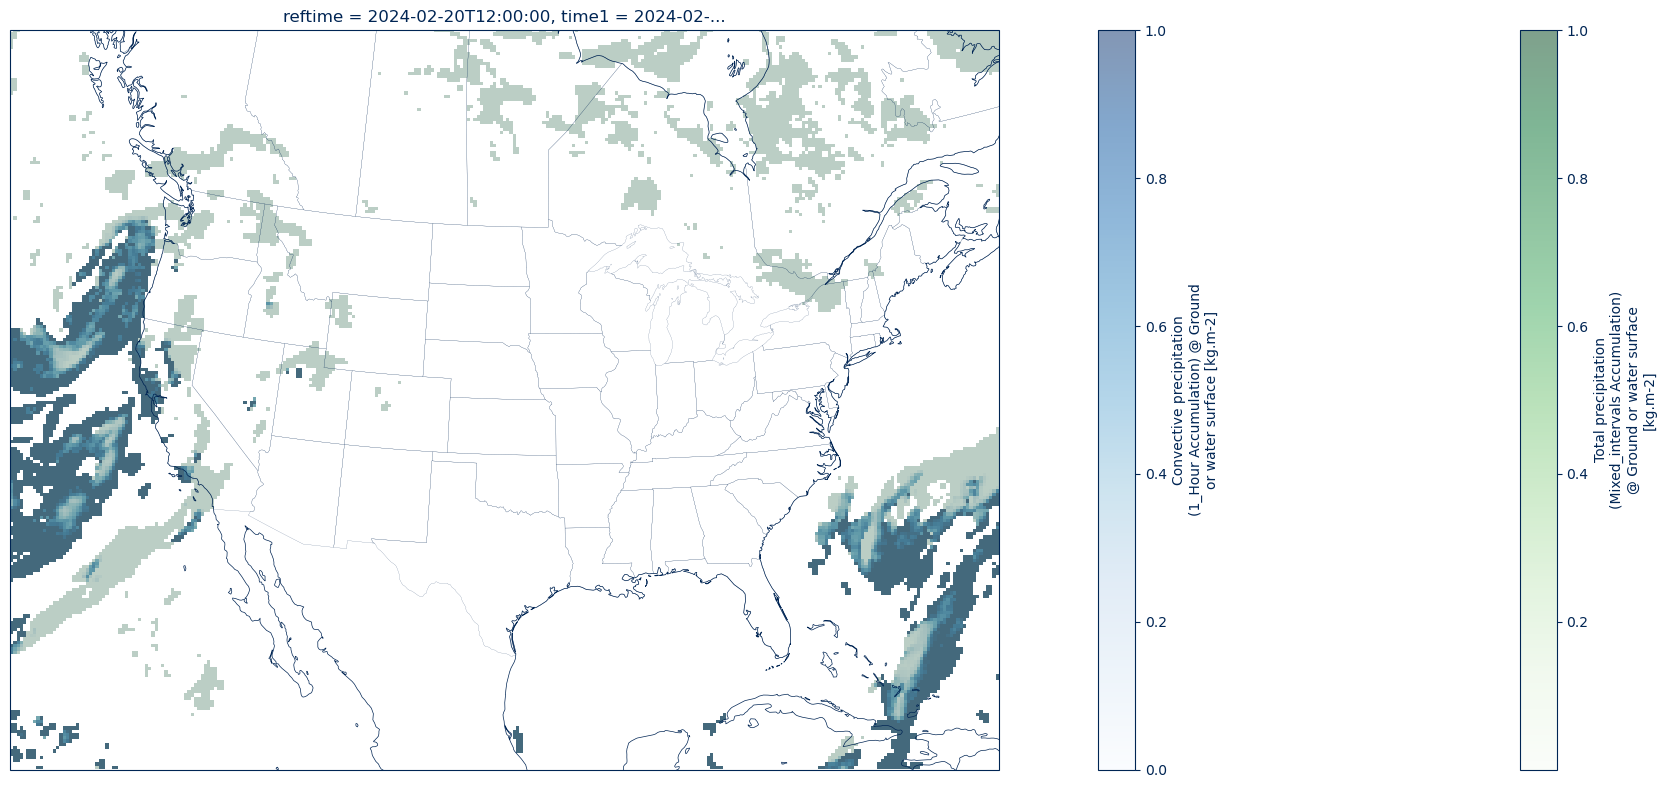

In [89]:
fig = plt.figure(figsize=[6.4*5,4.8*2])
ax  = fig.add_subplot(1, 1, 1, projection=hrrr_crs)
#prec_accum_acc.plot.imshow(cmap='Greys',   ax=ax, vmin = 0, transform = hrrr_crs,  alpha=0.5)
rain_accum_on.plot.imshow(cmap='Greens',  ax=ax, vmin = np.nanmin(rain_accum_acc.values), transform = hrrr_crs, alpha=0.5)
conv_accum_on.plot.imshow(cmap='Blues',   ax=ax, vmin = 0,  transform = hrrr_crs, alpha=0.5)
#snow_accum_on.plot.imshow(cmap='Blues',   ax=ax, vmin = 0,  transform = hrrr_crs, alpha=0.9)
#icep_accum_on.plot.imshow(cmap='Purples', ax=ax, vmin = 0,  transform = hrrr_crs, alpha=0.9)
#frzr_accum_on.plot.imshow(cmap='Reds',    ax=ax, vmin = 0,  transform = hrrr_crs, alpha=0.9)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), 
               linewidth = 0.5,
               edgecolor = Mines_Blue)
ax.add_feature(cfeature.STATES.with_scale('50m'), 
               linewidth = 0.1,
               edgecolor = Mines_Blue)
#vmax = np.nanmax(rain_accum_acc.values)
print(fig.get_figheight())
print(fig.get_figwidth())

In [84]:
print(np.nanmin(rain_accum_acc.values), np.nanmax(rain_accum_acc.values),np.nanmax(prec_accum_acc.values) )

0.00010000169 15.0 15.0


In [85]:
#######################################
#
# Convert to Hourly Extrapolation in Inches.
#



print("inches per hour", np.nanmin(water_equiv.values), np.nanmax(water_equiv.values))

min_rain =  0.005
max_rain =  1

min_snow =  0.0001
max_snow =  0.25

min_icep =  0.0001
max_icep =  0.25

min_frzr =  0.0001
max_frzr =  0.25

min_alpha = 0.25
max_alpha = 1.00



    

#
######################################






######################################
#
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1, projection=hrrr_crs)
ax2 = fig.add_subplot(2, 2, 2, projection=hrrr_crs)
ax3 = fig.add_subplot(2, 2, 3, projection=hrrr_crs)
ax4 = fig.add_subplot(2, 2, 4, projection=hrrr_crs)

rain.plot.imshow(cmap='Greens',  ax=ax1, transform = hrrr_crs, add_colorbar = False)
snow.plot.imshow(cmap='Blues',   ax=ax2, transform = hrrr_crs, add_colorbar = False)
icep.plot.imshow(cmap='Purples', ax=ax3, transform = hrrr_crs, add_colorbar = False)
frzr.plot.imshow(cmap='Reds',    ax=ax4, transform = hrrr_crs, add_colorbar = False)


ax1.set_title="Rain"
ax2.set_title="Snow"
ax3.set_title="Ice"
ax4.set_title="ZR"

ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), 
               linewidth = 0.5,
               edgecolor = Mines_Blue)
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), 
               linewidth = 0.5,
               edgecolor = Mines_Blue)
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'), 
               linewidth = 0.5,
               edgecolor = Mines_Blue)
ax4.add_feature(cfeature.COASTLINE.with_scale('50m'), 
               linewidth = 0.5,
               edgecolor = Mines_Blue)

ax1.add_feature(cfeature.STATES.with_scale('50m'), 
               linewidth = 0.1,
               edgecolor = Mines_Blue)
ax2.add_feature(cfeature.STATES.with_scale('50m'), 
               linewidth = 0.1,
               edgecolor = Mines_Blue)
ax3.add_feature(cfeature.STATES.with_scale('50m'), 
               linewidth = 0.1,
               edgecolor = Mines_Blue)
ax4.add_feature(cfeature.STATES.with_scale('50m'), 
               linewidth = 0.1,
               edgecolor = Mines_Blue)



plt.show()
#
######################################



water_equiv =  ds_hrrr["Precipitation_rate_surface"][0,:,:] #* 0.0393701 * 3600.0 
alpha = water_equiv
alpha.attrs["long_name"] = "Alpha"
alpha.values[water_equiv.values==0] = np.nan

alpha1d = alpha.values.flatten()[water_equiv.values.flatten()>0]

print(len(alpha1d))

print("qrate",(water_equiv.min().values, water_equiv.max().values))
print("alpha",(alpha.min().values, alpha.max().values))


alpha.plot.hist(bins=15)
plt.show()

ecdf = ECDF(alpha1d)
plt.plot(ecdf.x,ecdf.y)



alpha.values = ecdf(alpha.values)

#alpha.values[water_equiv.values==0] = np.nan



print(min_cdf_x,max_cdf_x )
print(min_cdf_P,max_cdf_P )
print(ecdf(min_cdf_x),ecdf(max_cdf_x) )


plt.show()



######################################
#
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection=hrrr_crs)


alpha.plot.imshow(cmap='Greys', ax=ax1, transform = hrrr_crs)




ax1.set_title="Alpha"


ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), 
               linewidth = 0.5,
               edgecolor = Mines_Blue)


ax1.add_feature(cfeature.STATES.with_scale('50m'), 
               linewidth = 0.1,
               edgecolor = Mines_Blue)




plt.show()
#
######################################



NameError: name 'water_equiv' is not defined

In [ ]:
alpha

In [150]:
def plot_clock_stationary(fig,time_utc):
    #####################################################
#

    axins = fig.add_axes(rect     =    [0,
                                        1-0.12, #0.015,
                                        0.12*8/9,
                                        0.12],
                          projection  =  "polar")
    
    time_for_clock = pd.to_datetime(time_utc).tz_localize(tz="UTC").tz_convert(tz=tz).time()
    
    hour   = time_for_clock.hour
    minute = time_for_clock.minute
    second = time_for_clock.second
    
    
    if ((hour >= 6) and (hour < 18)):
        Clock_Color = Mines_Blue
        Clock_BgndC = "white"           
    else:
        Clock_Color = "white"
        Clock_BgndC = Mines_Blue               
    
    
    circle_theta  = np.deg2rad(np.arange(0,360,0.01))
    circle_radius = circle_theta * 0 + 1
    
    if (hour > 12) :
        hour = hour - 12
    
    angles_h = 2*np.pi*hour/12+2*np.pi*minute/(12*60)+2*second/(12*60*60)
    angles_m = 2*np.pi*minute/60+2*np.pi*second/(60*60)
    

    
    
    plt.setp(axins.get_yticklabels(), visible=False)
    plt.setp(axins.get_xticklabels(), visible=False)
    axins.spines['polar'].set_visible(False)
    axins.set_ylim(0,1)
    axins.set_theta_zero_location('N')
    axins.set_theta_direction(-1)
    axins.set_facecolor(Clock_BgndC)
    axins.grid(False)
    
    axins.plot([angles_h,angles_h], [0,0.60], color=Clock_Color, linewidth=1.5, zorder=99999)
    axins.plot([angles_m,angles_m], [0,0.95], color=Clock_Color, linewidth=1.5, zorder=99999)
    axins.plot(circle_theta, circle_radius,  color=Mines_Blue, linewidth=1, zorder=99999)
#
##################################################

In [67]:
def plot_bulletin(ax, data):
    """Plot a dataframe of surface features on a map."""
    # Set some default visual styling
    size = 9
    fontsize = 10
    HLfontsize = 30
    spacing = 2

    
    complete_style = { 'HIGH': {'color': 'blue', 'fontsize': HLfontsize},
                        'LOW': {'color': 'darkred', 'fontsize': HLfontsize},
                       'WARM': {'linewidth': 1, 'path_effects': [WarmFront(size=size, spacing=spacing)]},
                       'COLD': {'linewidth': 1, 'path_effects': [ColdFront(size=size, spacing=spacing)]},
                      'OCFNT': {'linewidth': 1, 'path_effects': [OccludedFront(size=size, spacing=spacing)]},
                      'STNRY': {'linewidth': 1, 'path_effects': [StationaryFront(size=size, spacing=spacing)]},
                       'TROF': {'linewidth': 2, 'linestyle': 'dashed',
                                'edgecolor': 'brown'}}

    complete_stylet = {'HIGH': {'color': 'blue', 'fontsize': fontsize},
                      'LOW': {'color': 'darkred', 'fontsize': fontsize},
                      'WARM': {'linewidth': 1, 'path_effects': [WarmFront(size=size, spacing=spacing)]},
                      'COLD': {'linewidth': 1, 'path_effects': [ColdFront(size=size, spacing=1)]},
                      'OCFNT': {'linewidth': 1, 'path_effects': [OccludedFront(size=size, spacing=1)]},
                      'STNRY': {'linewidth': 1, 'path_effects': [StationaryFront(size=size, spacing=1)]},
                      'TROF': {'linewidth': 2, 'linestyle': 'dashed',
                               'edgecolor': 'brown'}}


    # Handle H/L points using MetPy's StationPlot class
    for field in ('HIGH', 'LOW'):
        rows = data[data.feature == field]
        x, y = zip(*((pt.x, pt.y) for pt in rows.geometry))
        sp = StationPlot(ax, x, y, transform=ccrs.PlateCarree(), clip_on=True)
        sp.plot_text('C', [field[0]] * len(x), **complete_style[field])
        sp.plot_parameter('S2', rows.strength, **complete_stylet[field])

    
    # Handle all the boundary types
    for field in ('WARM', 'COLD', 'STNRY', 'OCFNT', 'TROF'):
        rows = data[data.feature == field]
        ax.add_geometries(rows.geometry, crs=ccrs.PlateCarree(), **complete_style[field],
                          facecolor='none')


In [68]:
# Set up a default figure and map


myproj = ccrs.AlbersEqualArea(central_longitude  = -96.0, 
                              central_latitude   =  37.5, 
                              false_easting      =   0.0, 
                              false_northing     =   0.0, 
                              standard_parallels = (29.5, 45.5))

bbox = [-125,  -67,
          23,   53] 

bbox = [-125,  -67,
          23,   52] 

Lx = 14.152777777777779  
Ly =  9.88888888888889


time_utc = df["valid"][0].to_pydatetime()
valid_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").strftime("%Y-%m-%d %H%M %Z")
local_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").tz_convert(tz=tz).strftime("%Y-%m-%d %H%M %Z")





fig = plt.figure(figsize   = [Lx, Ly], 
                 facecolor = 'white')

ax = fig.add_subplot(1, 1, 1, 
                     projection=myproj)

plt.subplots_adjust(left   = 0.01, 
                    right  = 0.99, 
                    top    = 0.99, 
                    bottom = 0, 
                    wspace = 0)

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), 
               linewidth = 0.5,
               edgecolor = Mines_Blue)
ax.add_feature(cfeature.STATES.with_scale('50m'),    
               linewidth = 0.25, 
               edgecolor = Mines_Blue)
ax.add_feature(cfeature.LAKES.with_scale('50m'),   
               linewidth = 0.5,
               facecolor = "none", 
               edgecolor = Mines_Blue)

ax.set_frame_on(False)

ax.set_extent(bbox, crs=ccrs.PlateCarree())


###############################
#
# Fonts Fields
#

plot_bulletin(ax, df)

#
###############################

###############################
#
# NDFD Weather
#
#
#wx_code.plot.imshow(ax=ax, 
#                    alpha = 0.95,
#                    add_colorbar = False,
#                   transform = ndfd_crs,
#                   cmap = "nipy_spectral")
#
#
###############################



###############################
#
# HRRR Weather
#

clevels = np.arange(900,1200,4)
mslpplot = mslp.plot.contour(ax     = ax,
                             colors  = "#001633",
                             levels = clevels,
                             transform = hrrr_crs)
ax.clabel(mslpplot, 
          levels = mslpplot.levels, 
          colors = "#001633",
          inline=True, 
          fontsize=10)
#
###############################

###############################
#
# HRRR Weather
#
myalpha = 0.75

rain.plot.imshow(cmap='Greens',  vmax=1.2, vmin=0, alpha=myalpha, ax=ax, transform = hrrr_crs, add_colorbar = False)
snow.plot.imshow(cmap='Blues',   vmax=1.2, vmin=0, alpha=myalpha, ax=ax, transform = hrrr_crs, add_colorbar = False)
icep.plot.imshow(cmap='Purples', vmax=1.2, vmin=0, alpha=myalpha, ax=ax, transform = hrrr_crs, add_colorbar = False)
frzr.plot.imshow(cmap='Reds',    vmax=1.2, vmin=0, alpha=myalpha, ax=ax, transform = hrrr_crs, add_colorbar = False)

#
###############################


plt.suptitle("NWS-WPC Surface Analysis",
             fontsize = 30, 
             color    = Mines_Blue)

plot_clock_stationary(fig, time_utc)
ax.set_title(valid_time + "  (" + local_time+")",
             fontsize=20, 
             color=Mines_Blue)

plt.savefig("./temp_sfc_analysis/NWS_Sfc_Analysis.png",
                        facecolor   = 'white', 
                        transparent =   False)

plt.close()
os.system("mv -fv ./temp_sfc_analysis/NWS_Sfc_Analysis.png ./graphics_files/")





./temp_sfc_analysis/NWS_Sfc_Analysis.png -> ./graphics_files/NWS_Sfc_Analysis.png


0

In [47]:
print("Current Time ", current_datetime)
print("Product Time ", map_datetime)
print("  Label Time ", product_string_YYYY_MM_DD_HH00UTC)
print(" ")
print("- Fronts Time ", fronts_date_YYYYMMDD_HH00)
print(" ")
print("--- MSLP Time ", mslp.coords)
print(" ")
print("--- PREC Time ", water_equiv.coords)


Current Time  2024-02-16 15:29:11.010051
Product Time  2024-02-16 12:00:00
  Label Time  2024-02-16 1200 UTC
 
- Fronts Time  20240216_1200
 
--- MSLP Time  Coordinates:
    reftime    datetime64[ns] 2024-02-16T12:00:00
    time       datetime64[ns] 2024-02-16T12:00:00
  * x          (x) float32 -3.332e+06 -3.312e+06 ... 2.743e+06 2.763e+06
  * y          (y) float32 -5.889e+05 -5.686e+05 ... 3.942e+06 3.962e+06
    metpy_crs  object Projection: lambert_conformal_conic
 
--- PREC Time  Coordinates:
    reftime    datetime64[ns] 2024-02-16T12:00:00
    time       datetime64[ns] 2024-02-16T12:00:00
  * x          (x) float32 -3.332e+06 -3.312e+06 ... 2.743e+06 2.763e+06
  * y          (y) float32 -5.889e+05 -5.686e+05 ... 3.942e+06 3.962e+06
    metpy_crs  object Projection: lambert_conformal_conic


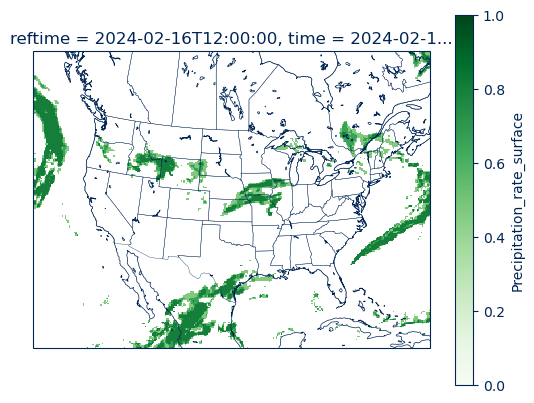

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=hrrr_crs)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), 
               linewidth = 0.5,
               edgecolor = Mines_Blue)
ax.add_feature(cfeature.STATES.with_scale('50m'),    
               linewidth = 0.25, 
               edgecolor = Mines_Blue)
ax.add_feature(cfeature.LAKES.with_scale('50m'),   
               linewidth = 0.5,
               facecolor = "none", 
               edgecolor = Mines_Blue)

alpha = np.sqrt(water_equiv)
alpha.values[alpha.values<0.5] = np.nan
alpha.values[alpha.values>1] = 1
alpha.values = alpha.values *.8
alpha.plot.imshow(cmap='Greens', alpha=alpha, vmax=1, vmin=0)



plt.show()

# 